<a href="https://colab.research.google.com/github/TechDailyNotes/study-notes-triton/blob/main/practice_01_vector_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import triton
import triton.language as tl
import triton.testing as testing

@triton.jit
def add_kernel(
    input1_ptr, input2_ptr, output_ptr, num_elements, BLOCK_SIZE:tl.constexpr,
):
    # Step 1: Get thread parameters.
    ptr_start = tl.program_id(0) * BLOCK_SIZE
    offsets = ptr_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < num_elements

    # Step 2: Load data.
    input1_ptrs = input1_ptr + offsets
    input2_ptrs = input2_ptr + offsets
    input1 = tl.load(input1_ptrs, mask=mask)
    input2 = tl.load(input2_ptrs, mask=mask)

    # Step 3: Compute data.
    output = input1 + input2

    # Step 4: Store data.
    output_ptrs = output_ptr + offsets
    tl.store(output_ptrs, output, mask=mask)

In [11]:
def add(x, y):
    # Step 1: Init output.
    z = torch.empty_like(x)

    # Step 2: Set kernel parameters.
    num_elements = x.numel()
    BLOCK_SIZE = 1024
    grid = lambda meta: (triton.cdiv(num_elements, meta["BLOCK_SIZE"]), )

    # Step 3: Launch kernel function.
    add_kernel[grid](x, y, z, num_elements, BLOCK_SIZE=BLOCK_SIZE)

    # Step 4: Return output.
    return z

In [9]:
torch.manual_seed(0)

num_elements = 98432
x = torch.rand(num_elements, dtype=torch.float32, device="cuda")
y = torch.rand(num_elements, dtype=torch.float32, device="cuda")

z_triton = add(x, y)
z_torch = x + y

print(f"min diff = {torch.max(torch.abs(z_triton - z_torch))}")
assert torch.allclose(z_triton, z_torch), (z_triton, z_torch)

min diff = 0.0


In [14]:
@testing.perf_report(testing.Benchmark(
    x_names=["size"], x_vals=[2 ** i for i in range(12, 28)], x_log=True,
    line_arg="provider", line_vals=["triton", "torch"],
    line_names=["Triton", "Torch"], ylabel="GB/s",
    styles=[("blue", "-"), ("green", "-")], plot_name="vector add performance",
    args={},
))
def benchmark(size, provider):
    # Step 1: Init inputs.
    x = torch.rand(size, dtype=torch.float32, device="cuda")
    y = torch.rand(size, dtype=torch.float32, device="cuda")

    # Step 2: Set benchmark parameters.
    quantiles = [0.5, 0.2, 0.8]

    # Step 3: Launch benchmark function.
    if provider == "triton":
        ms, min_ms, max_ms = testing.do_bench(
            lambda: add(x, y), quantiles=quantiles,
        )
    if provider == "torch":
        ms, min_ms, max_ms = testing.do_bench(
            lambda: x + y, quantiles=quantiles,
        )

    # Step 4: Compute throughput.
    gbps = lambda ms: x.numel() * x.element_size() * 3 / ms * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)

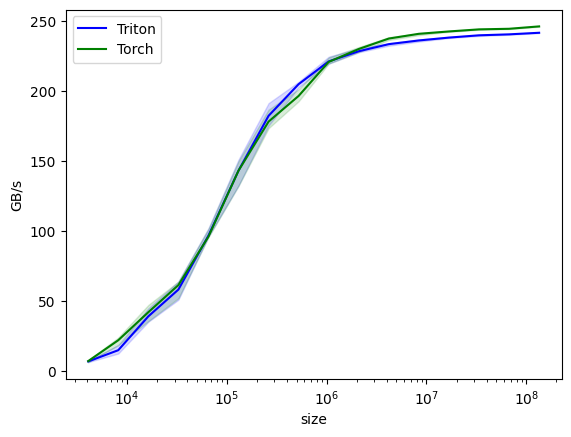

vector add performance:
           size      Triton       Torch
0        4096.0    6.965987    7.211268
1        8192.0   14.985366   22.100720
2       16384.0   39.133757   42.082190
3       32768.0   58.236965   61.440002
4       65536.0   96.755900   96.000000
5      131072.0  143.091705  143.091705
6      262144.0  182.213169  178.086953
7      524288.0  204.800005  196.411578
8     1048576.0  221.032035  220.659939
9     2097152.0  228.282153  229.883662
10    4194304.0  233.345293  237.341786
11    8388608.0  235.988589  240.738356
12   16777216.0  238.024212  242.412609
13   33554432.0  239.656258  243.887978
14   67108864.0  240.336019  244.311776
15  134217728.0  241.465959  246.012267


In [15]:
benchmark.run(show_plots=True, print_data=True)